In [492]:
import numpy as np
import pandas as pd
import sklearn.linear_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.optimize import minimize, fmin_tnc
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score

**Titanic**

In [493]:
Titanic=pd.read_csv("Titanic/tested.csv")

In [494]:
Titanic=Titanic.drop(columns=["PassengerId","Ticket","Name"])

In [495]:
Titanic.loc[pd.isna(Titanic.Cabin)==False,"Cabin"]=1

In [496]:
Titanic.loc[pd.isna(Titanic.Cabin)==True,"Cabin"]=0

In [497]:
Titanic.loc[:,"Sex"]=(Titanic.Sex=="male").astype(int)

In [498]:
Titanic.loc[pd.isna(Titanic.Age)==True,"Age"]=Titanic.Age.median()

In [499]:
Titanic=pd.get_dummies(Titanic,columns=["Embarked"], drop_first = True)

In [500]:
Titanic.loc[:,"Cabin"]=Titanic.loc[:,"Cabin"].astype(int)

In [501]:
Titanic = Titanic[~Titanic.isnull().any(axis = 1)]

In [502]:
Titanic = Titanic.drop(columns = ['Sex'])

**Diabets**

In [503]:
Diabetes=pd.read_csv("diabetes/dataset_37_diabetes.csv")

In [504]:
Diabetes.loc[:,"class"]=(Diabetes["class"]=="tested_positive").astype(int)

**Pokemon**

In [505]:
Pokemon=pd.read_csv("Pokemon/pokemon.csv")

In [506]:
Pokemon=Pokemon.filter(regex='^(?!against).*')

In [507]:
Pokemon=Pokemon.drop(columns=["abilities","classfication","pokedex_number","japanese_name","name"])

In [508]:
Pokemon.loc[pd.isna(Pokemon.height_m),"height_m"]=0

In [509]:
Pokemon.loc[pd.isna(Pokemon.percentage_male),"percentage_male"]=0

In [510]:
Pokemon.loc[pd.isna(Pokemon.weight_kg),"weight_kg"]=0

In [511]:
Pokemon.capture_rate=pd.to_numeric(Pokemon.capture_rate,errors="coerce")

In [512]:
Pokemon.loc[pd.isna(Pokemon.capture_rate),"capture_rate"]=255

In [513]:
types1=pd.get_dummies(Pokemon["type1"],columns=["type1"], drop_first = True)

In [514]:
types2=pd.get_dummies(Pokemon["type2"],columns=["type2"], drop_first = True)

In [515]:
Pokemon=Pokemon.drop(columns=["type1","type2"])

In [516]:
Pokemon=pd.concat([Pokemon,types2+types1], axis=1)

In [517]:
Pokemon=Pokemon[['base_egg_steps', 'base_happiness', 'base_total',
                'percentage_male', 'sp_attack', 'is_legendary']]

**Cancer**

In [518]:
Cancer=pd.read_csv("cancer/wdbc.data",header=None)

In [519]:
Cancer.iloc[:,1]=(Cancer[1]=="M").astype(int)

In [520]:
Cancer=Cancer.drop(columns=[0])

**Bank**

In [521]:
Bank=pd.read_csv("bank/bank.csv",sep=";")

In [522]:
Bank.loc[:,"default"]=(Bank.default=="yes").astype(int)

In [523]:
Bank.loc[:,"housing"]=(Bank.housing=="yes").astype(int)

In [524]:
Bank.loc[:,"loan"]=(Bank.loan=="yes").astype(int)

In [525]:
Bank.loc[:,"y"]=(Bank.y=="yes").astype(int)

In [526]:
Bank=pd.get_dummies(Bank, drop_first = True)

**Model assessement**

In [527]:
def accuracy(Y,Y_hat):
    temp=Y==Y_hat
    return np.mean(temp)

In [528]:
def precision(Y,Y_hat):
    tp=np.logical_and(Y,Y_hat)
    fp=np.logical_and(np.logical_not(Y),Y_hat)
    return np.sum(tp)/(np.sum(tp)+np.sum(fp))

In [529]:
def recall(Y,Y_hat):
    tp=np.logical_and(Y,Y_hat)
    fn=np.logical_and(Y,np.logical_not(Y_hat))
    return np.sum(tp)/(np.sum(tp)+np.sum(fn))

In [530]:
def F_measure(Y,Y_hat):
    pre=precision(Y,Y_hat)
    re=recall(Y,Y_hat)
    return 2*pre*re/(pre+re)

In [531]:
def assess(Y, Y_hat):
    print('Acccuracy: ', accuracy(Y, Y_hat))
    print('Precision: ', precision(Y, Y_hat))
    print('Recall: ', recall(Y, Y_hat))
    print('F_measure: ', F_measure(Y, Y_hat))
    print('R2_score: ', r2_score(Y, Y_hat))

**Auxiliary Gradient Descent Functions**

In [533]:
def MSE(Y,Y_hat):
    return np.sum((Y-Y_hat)**2)

def MSE_grad(Y,Y_hat):
     return Y_hat-Y

def sigmoid(x):
    return(1/(1 + np.exp(np.clip(-x,-100,100))))

def sigmoid_grad(x):
    return(sigmoid(x)*(1-sigmoid(x)))

def cross_entropy(Y, Y_hat,  epsilon=1e-10):
    Y_hat = np.clip(Y_hat, epsilon, 1-epsilon)
    return np.sum(np.log(Y_hat) * Y + np.log((1 - Y_hat)) * (1 - Y))

def cross_entropy_grad(Y,Y_hat,eps=10**-10):
    Y_hat=Y_hat+eps
    return (Y_hat-eps-Y)/Y_hat/(1-Y_hat)

In [534]:
class LogisticRegression:
    
    def __init__(self, solver: str, intercept: bool = True, iterations: int = 1000, 
                 alpha: int = None, batch_size: int = None, eps: float = 10**-8,
                 normalize: bool = False, tol: float = 0.0001):
        
        
        self.solver = solver
        self.intercept = intercept
        self.iterations = iterations
        self.batch_size = batch_size
        self.alpha = alpha
        self.normalize = normalize
        self.tolerance = tol
        self.epsilon = eps
        
    def fit(self, X, Y, verbose = False, save_errors = False):

        if self.normalize:
            self.std = X.std(0)
            self.mean = X.mean(0)
            X = (X-self.mean)/self.std
            
        if self.intercept:
            X = np.insert(X, 0, values=1, axis=1)
            
        self.Beta=np.zeros(X.shape[1])
        
        if self.solver == 'gd':
            self._gradient_descent(X, Y, X.shape[0], verbose, save_errors)
        elif self.solver == 'sgd':
            self._gradient_descent(X, Y, self.batch_size, verbose, save_errors)
        elif self.solver == 'powell':
            self._powell(X, Y)
        else:
            self._iwls(X, Y, verbose, save_errors)
    
    def _gradient_descent(self, X, Y, batch_size, verbose, save_errors):
        
        batches = np.linspace(0,X.shape[0],int(X.shape[0]/batch_size)+1).astype(int)
        
        if save_errors:
            self.errors = [cross_entropy(Y, sigmoid(X @ self.Beta))]
        
        for epoch in range(self.iterations):
            s = np.arange(0, X.shape[0], 1)
            np.random.shuffle(s)
            
            X = X[s,:]
            Y = Y[s]
            
            for b in range(len(batches)-1):
                X_b=X[batches[b]:batches[b+1],:]
                Y_b=Y[batches[b]:batches[b+1]]
                
                pred=sigmoid(X_b @ self.Beta)
                error=cross_entropy(Y_b,pred)
                
                delta = self.alpha * (X_b*(cross_entropy_grad(Y_b,pred) * sigmoid_grad(X_b @ self.Beta)).reshape(-1,1)).mean(axis=0)
                if abs(delta.max()) < self.tolerance:
                    return

                self.Beta = self.Beta - delta
                
            pred=sigmoid(X @ self.Beta)
            error=cross_entropy(Y,pred)
            
            if save_errors:
                self.errors.append(error)
            
            if verbose: 
                print('Iteration no.', epoch+1, ':', error)
                
    
    def _iwls(self, X, Y, verbose, save_errors):
        
        W = np.ones(X.shape[0])*0.5
        X1 = X[:,1:] if self.intercept else X
        
        if save_errors:
            self.errors = [cross_entropy(Y, sigmoid(X @ self.Beta))]
        
        for i in range(self.iterations):
            
            delta = np.linalg.inv((X.T * W[:,None].T) @ X) @ X.T @ (Y-self.predict(X1, _internal_pass = True))
            if abs(delta.max()) < self.tolerance:
                return
            
            self.Beta += delta

            W = (1-self.predict(X1, _internal_pass = True)) * self.predict(X1, _internal_pass = True) + self.epsilon
            
            pred = sigmoid(X @ self.Beta)
            error = cross_entropy(Y, pred)
            
            if save_errors:
                self.errors.append(error)
            
            if verbose: 
                print('Iteration no.', i+1, ':', error)

    def _powell(self, X, Y):
        self.Beta = minimize(fun = lambda x: -cross_entropy(Y, sigmoid(X @ x)), x0 = self.Beta, 
                             method = 'Powell',options={'xtol': self.tolerance, 'maxiter': self.iterations}).x
    
    def predict(self, X, rounding = False, _internal_pass = False):
        
        if (not _internal_pass) and self.normalize:
            X = (X-self.mean)/self.std
            
        if self.intercept:
            X = np.insert(X, 0, values=1, axis=1)
            
        ret = np.exp(np.clip(X @ self.Beta, -100, 100))/(1+np.exp(np.clip(X @ self.Beta, -100, 100)))
        
        if rounding:
            ret = ret.round()

        return ret
    

**Cancer**

In [535]:
np.random.seed(111)
Y = Cancer[1].to_numpy()
X = Cancer.loc[:,2:].to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [536]:
mod_sgd = LogisticRegression('sgd', alpha = 0.1, batch_size = 100, normalize = True)
mod_sgd.fit(X_train, Y_train, verbose = True, save_errors = True)
Y_hat_sgd = mod_sgd.predict(X_test, rounding = True)

Iteration no. 1 : -158.88853543873998
Iteration no. 2 : -122.54836267002526
Iteration no. 3 : -104.79193869519422
Iteration no. 4 : -93.67644596285164
Iteration no. 5 : -85.90976234839403
Iteration no. 6 : -80.08481651554257
Iteration no. 7 : -75.51958904525705
Iteration no. 8 : -71.82854021656377
Iteration no. 9 : -68.76492051604058
Iteration no. 10 : -66.17791351147598
Iteration no. 11 : -63.957563323457165
Iteration no. 12 : -62.02569002942504
Iteration no. 13 : -60.324667858113195
Iteration no. 14 : -58.81309073005618
Iteration no. 15 : -57.46085282318394
Iteration no. 16 : -56.239009970225396
Iteration no. 17 : -55.130403575841626
Iteration no. 18 : -54.11913544449864
Iteration no. 19 : -53.19089326194663
Iteration no. 20 : -52.33531202889323
Iteration no. 21 : -51.54382643547268
Iteration no. 22 : -50.80868885532783
Iteration no. 23 : -50.12300838871187
Iteration no. 24 : -49.482976662357835
Iteration no. 25 : -48.88278435917549
Iteration no. 26 : -48.31781844764684
Iteration no.

In [537]:
assess(Y_test, Y_hat_sgd)

Acccuracy:  0.9824561403508771
Precision:  0.9772727272727273
Recall:  0.9772727272727273
F_measure:  0.9772727272727273
R2_score:  0.925974025974026


In [538]:
mod_gd = LogisticRegression('gd', alpha = 0.1, normalize = True)
mod_gd.fit(X_train, Y_train, verbose = True, save_errors = True)
Y_hat_gd = mod_gd.predict(X_test, rounding = True)

Iteration no. 1 : -238.39442025702206
Iteration no. 2 : -199.1838275567015
Iteration no. 3 : -175.15119005756745
Iteration no. 4 : -158.58534542023472
Iteration no. 5 : -146.30025239474062
Iteration no. 6 : -136.7273345412594
Iteration no. 7 : -128.99689483808535
Iteration no. 8 : -122.58426869926276
Iteration no. 9 : -117.15231184289806
Iteration no. 10 : -112.47346058728112
Iteration no. 11 : -108.38793270588327
Iteration no. 12 : -104.77984191943087
Iteration no. 13 : -101.56282830820659
Iteration no. 14 : -98.67103678245002
Iteration no. 15 : -96.05324545738671
Iteration no. 16 : -93.6689243421358
Iteration no. 17 : -91.48551795602972
Iteration no. 18 : -89.47652731507092
Iteration no. 19 : -87.62012776469848
Iteration no. 20 : -85.89815438732809
Iteration no. 21 : -84.29534479927877
Iteration no. 22 : -82.79876554582755
Iteration no. 23 : -81.39737166563633
Iteration no. 24 : -80.08166432418673
Iteration no. 25 : -78.84342167415966
Iteration no. 26 : -77.67548509092961
Iteration n

Iteration no. 229 : -39.159833994605094
Iteration no. 230 : -39.11877891899857
Iteration no. 231 : -39.07798852880448
Iteration no. 232 : -39.03745990399863
Iteration no. 233 : -38.997190169563986
Iteration no. 234 : -38.95717649460761
Iteration no. 235 : -38.917416091498474
Iteration no. 236 : -38.87790621502575
Iteration no. 237 : -38.83864416157677
Iteration no. 238 : -38.79962726833438
Iteration no. 239 : -38.76085291249302
Iteration no. 240 : -38.72231851049301
Iteration no. 241 : -38.68402151727255
Iteration no. 242 : -38.645959425537086
Iteration no. 243 : -38.608129765045355
Iteration no. 244 : -38.570530101911814
Iteration no. 245 : -38.533158037924935
Iteration no. 246 : -38.49601120988109
Iteration no. 247 : -38.45908728893331
Iteration no. 248 : -38.422383979954866
Iteration no. 249 : -38.385899020917066
Iteration no. 250 : -38.34963018228096
Iteration no. 251 : -38.313575266402545
Iteration no. 252 : -38.277732106951234
Iteration no. 253 : -38.2420985683411
Iteration no. 2

Iteration no. 443 : -33.80235720185203
Iteration no. 444 : -33.78661711180386
Iteration no. 445 : -33.770927544060534
Iteration no. 446 : -33.75528821865014
Iteration no. 447 : -33.739698857811945
Iteration no. 448 : -33.724159185973704
Iteration no. 449 : -33.7086689297293
Iteration no. 450 : -33.69322781781671
Iteration no. 451 : -33.67783558109612
Iteration no. 452 : -33.66249195252841
Iteration no. 453 : -33.64719666715394
Iteration no. 454 : -33.631949462071425
Iteration no. 455 : -33.61675007641725
Iteration no. 456 : -33.60159825134498
Iteration no. 457 : -33.5864937300051
Iteration no. 458 : -33.571436257524994
Iteration no. 459 : -33.55642558098919
Iteration no. 460 : -33.541461449419856
Iteration no. 461 : -33.52654361375748
Iteration no. 462 : -33.51167182684181
Iteration no. 463 : -33.49684584339296
Iteration no. 464 : -33.48206541999267
Iteration no. 465 : -33.46733031506565
Iteration no. 466 : -33.45264028886053
Iteration no. 467 : -33.43799510342895
Iteration no. 468 : -

Iteration no. 677 : -31.089530871623346
Iteration no. 678 : -31.080897890314972
Iteration no. 679 : -31.07228283555309
Iteration no. 680 : -31.063685643091944
Iteration no. 681 : -31.05510624900974
Iteration no. 682 : -31.046544589706524
Iteration no. 683 : -31.03800060190208
Iteration no. 684 : -31.0294742226338
Iteration no. 685 : -31.02096538925462
Iteration no. 686 : -31.012474039430955
Iteration no. 687 : -31.00400011114067
Iteration no. 688 : -30.995543542671022
Iteration no. 689 : -30.987104272616644
Iteration no. 690 : -30.978682239877564
Iteration no. 691 : -30.970277383657233
Iteration no. 692 : -30.961889643460516
Iteration no. 693 : -30.95351895909179
Iteration no. 694 : -30.945165270652975
Iteration no. 695 : -30.936828518541624
Iteration no. 696 : -30.928508643449028
Iteration no. 697 : -30.920205586358314
Iteration no. 698 : -30.911919288542585
Iteration no. 699 : -30.90364969156305
Iteration no. 700 : -30.895396737267177
Iteration no. 701 : -30.887160367786862
Iteration

Iteration no. 910 : -29.458693785715703
Iteration no. 911 : -29.45298980588465
Iteration no. 912 : -29.447294535179346
Iteration no. 913 : -29.441607950145432
Iteration no. 914 : -29.435930027415914
Iteration no. 915 : -29.430260743710747
Iteration no. 916 : -29.42460007583647
Iteration no. 917 : -29.418948000685756
Iteration no. 918 : -29.41330449523697
Iteration no. 919 : -29.407669536553836
Iteration no. 920 : -29.402043101784955
Iteration no. 921 : -29.396425168163436
Iteration no. 922 : -29.39081571300649
Iteration no. 923 : -29.385214713715015
Iteration no. 924 : -29.379622147773212
Iteration no. 925 : -29.3740379927482
Iteration no. 926 : -29.368462226289573
Iteration no. 927 : -29.36289482612907
Iteration no. 928 : -29.35733577008015
Iteration no. 929 : -29.351785036037615
Iteration no. 930 : -29.34624260197721
Iteration no. 931 : -29.340708445955272
Iteration no. 932 : -29.335182546108324
Iteration no. 933 : -29.329664880652714
Iteration no. 934 : -29.324155427884214
Iteration

In [539]:
assess(Y_test, Y_hat_gd)

Acccuracy:  0.9736842105263158
Precision:  0.9767441860465116
Recall:  0.9545454545454546
F_measure:  0.9655172413793104
R2_score:  0.888961038961039


In [540]:
mod_iwls = LogisticRegression('iwls', normalize = True, eps = 10**-6)
mod_iwls.fit(X_train, Y_train, verbose = True, save_errors = True)
Y_hat_iwls = mod_iwls.predict(X_test, rounding = True)

Iteration no. 1 : -179.03412927320997
Iteration no. 2 : -87.78824330381084
Iteration no. 3 : -52.682820936331524
Iteration no. 4 : -34.924794025123575
Iteration no. 5 : -24.84174200100493
Iteration no. 6 : -17.401738579899735
Iteration no. 7 : -10.731459574525385
Iteration no. 8 : -6.137317083710444
Iteration no. 9 : -2.907393725265788
Iteration no. 10 : -1.232189404937082
Iteration no. 11 : -0.5280352783840314
Iteration no. 12 : -0.25745655194712114
Iteration no. 13 : -0.14794630370453932
Iteration no. 14 : -0.09768520655388861
Iteration no. 15 : -0.07106526422893836
Iteration no. 16 : -0.05517797243710333
Iteration no. 17 : -0.04481179647394013
Iteration no. 18 : -0.03758749548822466
Iteration no. 19 : -0.03229635263578271
Iteration no. 20 : -0.02826930564260975
Iteration no. 21 : -0.025109728270150233
Iteration no. 22 : -0.022569094930555547
Iteration no. 23 : -0.020484438179985423
Iteration no. 24 : -0.018744778405568003
Iteration no. 25 : -0.017272094967547988
Iteration no. 26 : -

Iteration no. 215 : -0.0010490658813261775
Iteration no. 216 : -0.0010438811042907002
Iteration no. 217 : -0.0010387472695577741
Iteration no. 218 : -0.0010336636305744431
Iteration no. 219 : -0.0010286294552948184
Iteration no. 220 : -0.0010236440258331817
Iteration no. 221 : -0.00101870663811987
Iteration no. 222 : -0.0010138166015695926
Iteration no. 223 : -0.001008973238766297
Iteration no. 224 : -0.0010041758851445904
Iteration no. 225 : -0.0009994238886897075
Iteration no. 226 : -0.0009947166096420292
Iteration no. 227 : -0.0009900534202120395
Iteration no. 228 : -0.0009854337042977288
Iteration no. 229 : -0.0009808568572197583
Iteration no. 230 : -0.0009763222854518563
Iteration no. 231 : -0.0009718294063714176
Iteration no. 232 : -0.0009673776480053338
Iteration no. 233 : -0.0009629664487893679
Iteration no. 234 : -0.0009585952573344138
Iteration no. 235 : -0.0009542635321929788
Iteration no. 236 : -0.0009499707416416561
Iteration no. 237 : -0.0009457163634594872
Iteration no. 

Iteration no. 427 : -0.0005108262088989875
Iteration no. 428 : -0.0005095924503183707
Iteration no. 429 : -0.0005083646343410351
Iteration no. 430 : -0.0005071427181504509
Iteration no. 431 : -0.0005059266593403457
Iteration no. 432 : -0.0005047164159084855
Iteration no. 433 : -0.0005035119462542322
Iteration no. 434 : -0.0005023132091753243
Iteration no. 435 : -0.0005011201638553299
Iteration no. 436 : -0.0004999327698677549
Iteration no. 437 : -0.0004987509871669383
Iteration no. 438 : -0.0004975747760839448
Iteration no. 439 : -0.00049640409732512
Iteration no. 440 : -0.0004952389119618764
Iteration no. 441 : -0.0004940791814336913
Iteration no. 442 : -0.0004929248675357824
Iteration no. 443 : -0.0004917759324233259
Iteration no. 444 : -0.000490632338600355
Iteration no. 445 : -0.0004894940489203134
Iteration no. 446 : -0.0004883610265782846
Iteration no. 447 : -0.00048723323510988035
Iteration no. 448 : -0.0004861106383884657
Iteration no. 449 : -0.00048499320061616514
Iteration no

Iteration no. 643 : -0.0003354001127314507
Iteration no. 644 : -0.0003348676507336174
Iteration no. 645 : -0.00033433687631342717
Iteration no. 646 : -0.00033380778146165253
Iteration no. 647 : -0.0003332803582210271
Iteration no. 648 : -0.0003327545986845796
Iteration no. 649 : -0.0003322304949936361
Iteration no. 650 : -0.0003317080393402619
Iteration no. 651 : -0.0003311872239644865
Iteration no. 652 : -0.0003306680411571896
Iteration no. 653 : -0.0003301504832536622
Iteration no. 654 : -0.00032963454264071186
Iteration no. 655 : -0.0003291202117507784
Iteration no. 656 : -0.0003286074830641547
Iteration no. 657 : -0.00032809634910698773
Iteration no. 658 : -0.00032758680245383243
Iteration no. 659 : -0.0003270788357229886
Iteration no. 660 : -0.0003265724415779443
Iteration no. 661 : -0.0003260676127315945
Iteration no. 662 : -0.00032556434193769255
Iteration no. 663 : -0.00032506262199529076
Iteration no. 664 : -0.0003245624457498511
Iteration no. 665 : -0.00032406380608924763
Ite

Iteration no. 848 : -0.00025294514404723266
Iteration no. 849 : -0.00025264215982868184
Iteration no. 850 : -0.00025233990052700634
Iteration no. 851 : -0.000252038363545099
Iteration no. 852 : -0.0002517375462961778
Iteration no. 853 : -0.00025143744620767256
Iteration no. 854 : -0.0002511380607192256
Iteration no. 855 : -0.0002508393872800277
Iteration no. 856 : -0.00025054142335425797
Iteration no. 857 : -0.00025024416641675424
Iteration no. 858 : -0.0002499476139560105
Iteration no. 859 : -0.0002496517634689588
Iteration no. 860 : -0.00024935661246807463
Iteration no. 861 : -0.000249062158475271
Iteration no. 862 : -0.00024876839902478453
Iteration no. 863 : -0.00024847533166350906
Iteration no. 864 : -0.00024818295394810866
Iteration no. 865 : -0.00024789126344734925
Iteration no. 866 : -0.00024760025774209855
Iteration no. 867 : -0.0002473099344237719
Iteration no. 868 : -0.0002470202910956642
Iteration no. 869 : -0.00024673132537172916
Iteration no. 870 : -0.00024644303487835514

In [541]:
assess(Y_test, Y_hat_iwls)

Acccuracy:  0.9298245614035088
Precision:  0.9090909090909091
Recall:  0.9090909090909091
F_measure:  0.9090909090909091
R2_score:  0.7038961038961039


In [542]:
mod_powell = LogisticRegression('powell', normalize = True)
mod_powell.fit(X_train, Y_train)
Y_hat_powell = mod_iwls.predict(X_test, rounding = True)

In [543]:
assess(Y_test, Y_hat_powell)

Acccuracy:  0.9298245614035088
Precision:  0.9090909090909091
Recall:  0.9090909090909091
F_measure:  0.9090909090909091
R2_score:  0.7038961038961039


In [544]:
X_train_norm, X_test_norm = (X_train-X_train.mean(0))/X_train.std(0), (X_test-X_train.mean(0))/X_train.std(0)
model = sklearn.linear_model.LogisticRegression()
result = model.fit(X_train_norm, Y_train)
Y_hat = result.predict(X_test_norm)

In [545]:
assess(Y_test, Y_hat)

Acccuracy:  0.9649122807017544
Precision:  0.9761904761904762
Recall:  0.9318181818181818
F_measure:  0.9534883720930233
R2_score:  0.851948051948052


In [546]:
mod_lda = LinearDiscriminantAnalysis()
mod_lda = mod_lda.fit(X_train_norm, Y_train)
Y_hat_lda = mod_lda.predict(X_test_norm)

In [547]:
assess(Y_test, Y_hat_lda)

Acccuracy:  0.956140350877193
Precision:  1.0
Recall:  0.8863636363636364
F_measure:  0.9397590361445783
R2_score:  0.814935064935065


In [548]:
mod_qda = QuadraticDiscriminantAnalysis()
mod_qda = mod_qda.fit(X_train_norm, Y_train)
Y_hat_qda = mod_qda.predict(X_test_norm)

In [549]:
assess(Y_test, Y_hat_qda)

Acccuracy:  0.9736842105263158
Precision:  0.9361702127659575
Recall:  1.0
F_measure:  0.967032967032967
R2_score:  0.888961038961039


In [550]:
mod_knn = KNeighborsClassifier(n_neighbors=5)
mod_knn.fit(X_train_norm, Y_train)
Y_hat_knn = mod_knn.predict(X_test_norm)

In [551]:
assess(Y_test, Y_hat_knn)

Acccuracy:  0.9824561403508771
Precision:  0.9772727272727273
Recall:  0.9772727272727273
F_measure:  0.9772727272727273
R2_score:  0.925974025974026


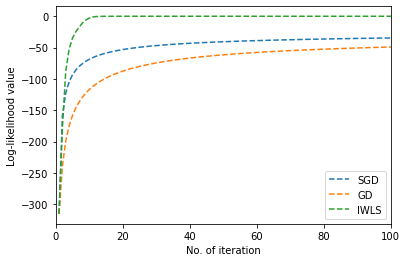

In [553]:
ax = plt.subplot(1,1,1)
plt.plot(list(range(1,len(mod_sgd.errors)+1)), mod_sgd.errors, '--')
plt.plot(list(range(1,len(mod_gd.errors)+1)), mod_gd.errors, '--')
plt.plot(list(range(1,len(mod_iwls.errors)+1)), mod_iwls.errors,'--')
plt.ylabel('Log-likelihood value')
plt.xlabel('No. of iteration')
ax.legend(['SGD', 'GD', 'IWLS'])
plt.xlim(0,100)
plt.show()

In [393]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 4, 8]
accuracies = []
precisions = []
recalls = []
f_measures = []

for alpha in alphas:
    current_model = LogisticRegression('sgd', alpha = alpha, batch_size = 200, normalize = True)
    current_model.fit(X_train, Y_train)
    cur_Y_hat = current_model.predict(X_test, rounding = True)
    accuracies.append(accuracy(Y_test, cur_Y_hat))
    precisions.append(precision(Y_test, cur_Y_hat))
    recalls.append(recall(Y_test, cur_Y_hat))
    f_measures.append(F_measure(Y_test, cur_Y_hat))

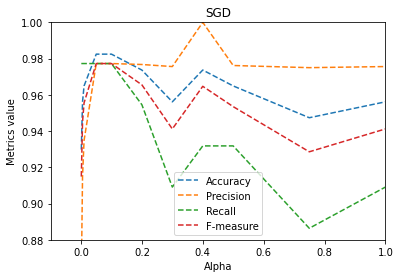

In [394]:
ax = plt.subplot(1,1,1)
plt.plot(alphas, accuracies, '--')
plt.plot(alphas, precisions, '--')
plt.plot(alphas, recalls, '--')
plt.plot(alphas, f_measures, '--')
plt.ylabel('Metrics value')
plt.xlabel('Alpha')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.xlim(-0.1,1)
plt.ylim(0.88,1)
plt.title("SGD")
plt.show()

In [395]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 4, 8]
accuracies = []
precisions = []
recalls = []
f_measures = []

for alpha in alphas:
    current_model = LogisticRegression('gd', alpha = alpha, batch_size = 200, normalize = True)
    current_model.fit(X_train, Y_train)
    cur_Y_hat = current_model.predict(X_test, rounding = True)
    accuracies.append(accuracy(Y_test, cur_Y_hat))
    precisions.append(precision(Y_test, cur_Y_hat))
    recalls.append(recall(Y_test, cur_Y_hat))
    f_measures.append(F_measure(Y_test, cur_Y_hat))

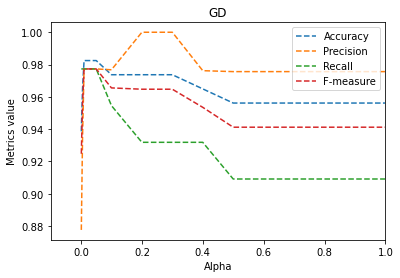

In [396]:
ax = plt.subplot(1,1,1)
plt.plot(alphas, accuracies, '--')
plt.plot(alphas, precisions, '--')
plt.plot(alphas, recalls, '--')
plt.plot(alphas, f_measures, '--')
plt.ylabel('Metrics value')
plt.xlabel('Alpha')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.xlim(-0.1,1)
plt.title("GD")
plt.show()

**Bank**

In [554]:
np.random.seed(111)
Y = Bank['y'].to_numpy()
X = Bank.drop(columns=['y']).to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [555]:
mod_sgd = LogisticRegression('sgd', alpha = 0.5, batch_size = 1000, normalize = True)
mod_sgd.fit(X_train, Y_train, save_errors = True)
Y_hat_sgd = mod_sgd.predict(X_test, rounding = True)

In [556]:
assess(Y_test, Y_hat_sgd)

Acccuracy:  0.8994475138121547
Precision:  0.717948717948718
Recall:  0.25925925925925924
F_measure:  0.38095238095238093
R2_score:  0.04322923927691824


In [557]:
mod_gd = LogisticRegression('gd', alpha = 0.5, normalize = True)
mod_gd.fit(X_train, Y_train, save_errors = True)
Y_hat_gd = mod_gd.predict(X_test, rounding = True)

In [558]:
assess(Y_test, Y_hat_gd)

Acccuracy:  0.8994475138121547
Precision:  0.717948717948718
Recall:  0.25925925925925924
F_measure:  0.38095238095238093
R2_score:  0.04322923927691824


In [559]:
mod_iwls = LogisticRegression('iwls', normalize = True, eps = 10**-8)
mod_iwls.fit(X_train, Y_train, save_errors = True)
Y_hat_iwls = mod_iwls.predict(X_test, rounding = True)

In [560]:
assess(Y_test, Y_hat_iwls)

Acccuracy:  0.8994475138121547
Precision:  0.717948717948718
Recall:  0.25925925925925924
F_measure:  0.38095238095238093
R2_score:  0.04322923927691824


In [561]:
mod_powell = LogisticRegression('powell', normalize = True)
mod_powell.fit(X_train, Y_train)
Y_hat_powell = mod_iwls.predict(X_test, rounding = True)

In [562]:
assess(Y_test, Y_hat_powell)

Acccuracy:  0.8994475138121547
Precision:  0.717948717948718
Recall:  0.25925925925925924
F_measure:  0.38095238095238093
R2_score:  0.04322923927691824


In [563]:
X_train_norm, X_test_norm = (X_train-X_train.mean(0))/X_train.std(0), (X_test-X_train.mean(0))/X_train.std(0)
model = sklearn.linear_model.LogisticRegression()
result = model.fit(X_train_norm, Y_train)
Y_hat = result.predict(X_test_norm)

In [564]:
assess(Y_test, Y_hat)

Acccuracy:  0.8994475138121547
Precision:  0.717948717948718
Recall:  0.25925925925925924
F_measure:  0.38095238095238093
R2_score:  0.04322923927691824


In [565]:
mod_lda = LinearDiscriminantAnalysis()
mod_lda = mod_lda.fit(X_train_norm, Y_train)
Y_hat_lda = mod_lda.predict(X_test_norm)

In [566]:
assess(Y_test, Y_hat_lda)

Acccuracy:  0.8983425414364641
Precision:  0.6142857142857143
Recall:  0.39814814814814814
F_measure:  0.48314606741573035
R2_score:  0.032715274873367894


In [567]:
mod_qda = QuadraticDiscriminantAnalysis()
mod_qda = mod_qda.fit(X_train_norm, Y_train)
Y_hat_qda = mod_qda.predict(X_test_norm)

In [568]:
assess(Y_test, Y_hat_qda)

Acccuracy:  0.8519337016574585
Precision:  0.3984375
Recall:  0.4722222222222222
F_measure:  0.43220338983050843
R2_score:  -0.4088712300757469


In [569]:
mod_knn = KNeighborsClassifier(n_neighbors=5)
mod_knn.fit(X_train_norm, Y_train)
Y_hat_knn = mod_knn.predict(X_test_norm)

In [570]:
assess(Y_test, Y_hat_knn)

Acccuracy:  0.8883977900552487
Precision:  0.5945945945945946
Recall:  0.2037037037037037
F_measure:  0.30344827586206896
R2_score:  -0.061910404758585225


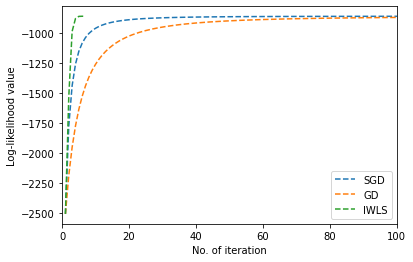

In [572]:
ax = plt.subplot(1,1,1)
plt.plot(list(range(1,len(mod_sgd.errors)+1)), mod_sgd.errors, '--')
plt.plot(list(range(1,len(mod_gd.errors)+1)), mod_gd.errors, '--')
plt.plot(list(range(1,len(mod_iwls.errors)+1)), mod_iwls.errors,'--')
plt.ylabel('Log-likelihood value')
plt.xlabel('No. of iteration')
ax.legend(['SGD', 'GD', 'IWLS'])
plt.xlim(0,100)
plt.show()

In [239]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 4, 8]
accuracies = []
precisions = []
recalls = []
f_measures = []

for alpha in alphas:
    current_model = LogisticRegression('sgd', alpha = alpha, batch_size = 200, normalize = True)
    current_model.fit(X_train, Y_train)
    cur_Y_hat = current_model.predict(X_test, rounding = True)
    accuracies.append(accuracy(Y_test, cur_Y_hat))
    precisions.append(precision(Y_test, cur_Y_hat))
    recalls.append(recall(Y_test, cur_Y_hat))
    f_measures.append(F_measure(Y_test, cur_Y_hat))

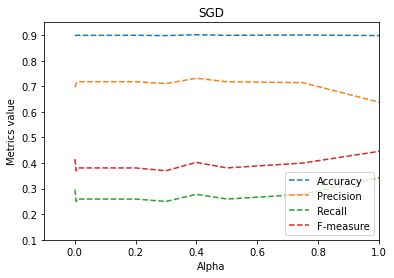

In [246]:
ax = plt.subplot(1,1,1)
plt.plot(alphas, accuracies, '--')
plt.plot(alphas, precisions, '--')
plt.plot(alphas, recalls, '--')
plt.plot(alphas, f_measures, '--')
plt.ylabel('Metrics value')
plt.xlabel('Alpha')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.title("SGD")
plt.xlim(-0.1,1)
plt.ylim(0.1,0.95)
plt.show()

In [247]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 4, 8]
accuracies = []
precisions = []
recalls = []
f_measures = []

for alpha in alphas:
    current_model = LogisticRegression('gd', alpha = alpha, batch_size = 200, normalize = True)
    current_model.fit(X_train, Y_train)
    cur_Y_hat = current_model.predict(X_test, rounding = True)
    accuracies.append(accuracy(Y_test, cur_Y_hat))
    precisions.append(precision(Y_test, cur_Y_hat))
    recalls.append(recall(Y_test, cur_Y_hat))
    f_measures.append(F_measure(Y_test, cur_Y_hat))

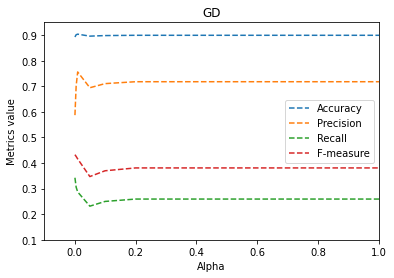

In [248]:
ax = plt.subplot(1,1,1)
plt.plot(alphas, accuracies, '--')
plt.plot(alphas, precisions, '--')
plt.plot(alphas, recalls, '--')
plt.plot(alphas, f_measures, '--')
plt.ylabel('Metrics value')
plt.xlabel('Alpha')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.title("GD")
plt.xlim(-0.1,1)
plt.ylim(0.1,0.95)
plt.show()

**Pokemon**

In [573]:
np.random.seed(111)
Y = Pokemon["is_legendary"].to_numpy()
X = Pokemon.drop(columns=["is_legendary"]).to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [574]:
mod_sgd = LogisticRegression('sgd', alpha = 0.01, batch_size = 200, normalize = True)
mod_sgd.fit(X_train, Y_train, save_errors = True)
Y_hat_sgd = mod_sgd.predict(X_test, rounding = True)

In [575]:
assess(Y_test, Y_hat_sgd)

Acccuracy:  0.9813664596273292
Precision:  0.9090909090909091
Recall:  0.8333333333333334
F_measure:  0.8695652173913043
R2_score:  0.7298657718120806


In [576]:
mod_gd = LogisticRegression('gd', alpha = 0.01, normalize = True)
mod_gd.fit(X_train, Y_train, save_errors = True)
Y_hat_gd = mod_gd.predict(X_test, rounding = True)

In [577]:
assess(Y_test, Y_hat_gd)

Acccuracy:  0.9813664596273292
Precision:  0.9090909090909091
Recall:  0.8333333333333334
F_measure:  0.8695652173913043
R2_score:  0.7298657718120806


In [578]:
mod_iwls = LogisticRegression('iwls', normalize = True, eps = 10**-6)
mod_iwls.fit(X_train, Y_train, save_errors = True)
Y_hat_iwls = mod_iwls.predict(X_test, rounding = True)

In [579]:
assess(Y_test, Y_hat_iwls)

Acccuracy:  0.9627329192546584
Precision:  0.7142857142857143
Recall:  0.8333333333333334
F_measure:  0.7692307692307692
R2_score:  0.45973154362416113


In [580]:
mod_powell = LogisticRegression('powell', normalize = True)
mod_powell.fit(X_train, Y_train)
Y_hat_powell = mod_iwls.predict(X_test, rounding = True)

In [581]:
assess(Y_test, Y_hat_powell)

Acccuracy:  0.9627329192546584
Precision:  0.7142857142857143
Recall:  0.8333333333333334
F_measure:  0.7692307692307692
R2_score:  0.45973154362416113


In [582]:
X_train_norm, X_test_norm = (X_train-X_train.mean(0))/X_train.std(0), (X_test-X_train.mean(0))/X_train.std(0)
model = sklearn.linear_model.LogisticRegression()
result = model.fit(X_train_norm, Y_train)
Y_hat = result.predict(X_test_norm)

In [583]:
assess(Y_test, Y_hat)

Acccuracy:  0.9751552795031055
Precision:  0.8333333333333334
Recall:  0.8333333333333334
F_measure:  0.8333333333333334
R2_score:  0.639821029082774


In [584]:
mod_lda = LinearDiscriminantAnalysis()
mod_lda = mod_lda.fit(X_train_norm, Y_train)
Y_hat_lda = mod_lda.predict(X_test_norm)

In [585]:
assess(Y_test, Y_hat_lda)

Acccuracy:  0.9813664596273292
Precision:  0.9090909090909091
Recall:  0.8333333333333334
F_measure:  0.8695652173913043
R2_score:  0.7298657718120806


In [586]:
mod_qda = QuadraticDiscriminantAnalysis()
mod_qda = mod_qda.fit(X_train_norm, Y_train)
Y_hat_qda = mod_qda.predict(X_test_norm)

In [587]:
assess(Y_test, Y_hat_qda)

Acccuracy:  0.9565217391304348
Precision:  0.6666666666666666
Recall:  0.8333333333333334
F_measure:  0.7407407407407408
R2_score:  0.3696868008948546


In [588]:
mod_knn = KNeighborsClassifier(n_neighbors=5)
mod_knn.fit(X_train_norm, Y_train)
Y_hat_knn = mod_knn.predict(X_test_norm)

In [589]:
assess(Y_test, Y_hat_knn)

Acccuracy:  0.9751552795031055
Precision:  0.8333333333333334
Recall:  0.8333333333333334
F_measure:  0.8333333333333334
R2_score:  0.639821029082774


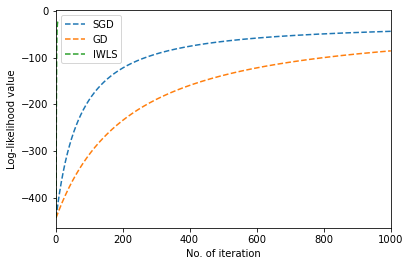

In [591]:
ax = plt.subplot(1,1,1)
plt.plot(list(range(1,len(mod_sgd.errors)+1)), mod_sgd.errors, '--')
plt.plot(list(range(1,len(mod_gd.errors)+1)), mod_gd.errors, '--')
plt.plot(list(range(1,len(mod_iwls.errors)+1)), mod_iwls.errors,'--')
plt.ylabel('Log-likelihood value')
plt.xlabel('No. of iteration')
ax.legend(['SGD', 'GD', 'IWLS'])
plt.xlim(0,1000)
plt.show()

In [433]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 4, 8]
accuracies = []
precisions = []
recalls = []
f_measures = []

for alpha in alphas:
    current_model = LogisticRegression('sgd', alpha = alpha, batch_size = 200, normalize = True)
    current_model.fit(X_train, Y_train)
    cur_Y_hat = current_model.predict(X_test, rounding = True)
    accuracies.append(accuracy(Y_test, cur_Y_hat))
    precisions.append(precision(Y_test, cur_Y_hat))
    recalls.append(recall(Y_test, cur_Y_hat))
    f_measures.append(F_measure(Y_test, cur_Y_hat))

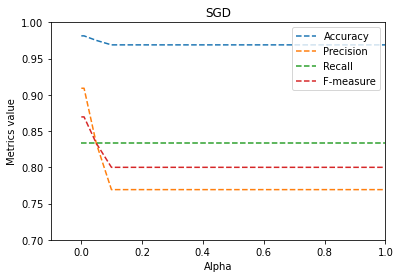

In [436]:
ax = plt.subplot(1,1,1)
plt.plot(alphas, accuracies, '--')
plt.plot(alphas, precisions, '--')
plt.plot(alphas, recalls, '--')
plt.plot(alphas, f_measures, '--')
plt.ylabel('Metrics value')
plt.xlabel('Alpha')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.title("SGD")
plt.xlim(-0.1,1)
plt.ylim(0.7,1,1)
plt.show()

In [437]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 4, 8]
accuracies = []
precisions = []
recalls = []
f_measures = []

for alpha in alphas:
    current_model = LogisticRegression('gd', alpha = alpha, batch_size = 200, normalize = True)
    current_model.fit(X_train, Y_train)
    cur_Y_hat = current_model.predict(X_test, rounding = True)
    accuracies.append(accuracy(Y_test, cur_Y_hat))
    precisions.append(precision(Y_test, cur_Y_hat))
    recalls.append(recall(Y_test, cur_Y_hat))
    f_measures.append(F_measure(Y_test, cur_Y_hat))

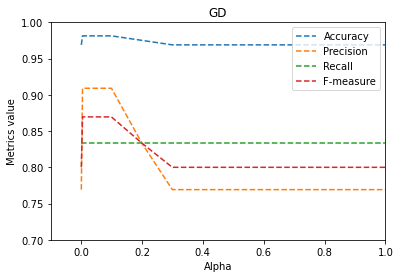

In [438]:
ax = plt.subplot(1,1,1)
plt.plot(alphas, accuracies, '--')
plt.plot(alphas, precisions, '--')
plt.plot(alphas, recalls, '--')
plt.plot(alphas, f_measures, '--')
plt.ylabel('Metrics value')
plt.xlabel('Alpha')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.title("GD")
plt.xlim(-0.1,1)
plt.ylim(0.7,1,1)
plt.show()

**Diabetes**

In [592]:
np.random.seed(111)
Y = Diabetes["class"].to_numpy()
X = Diabetes.drop(columns=["class"]).to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [593]:
mod_sgd = LogisticRegression('sgd', alpha = 0.5, batch_size = 200, normalize = True)
mod_sgd.fit(X_train, Y_train, save_errors = True)
Y_hat_sgd = mod_sgd.predict(X_test, rounding = True)

In [594]:
assess(Y_test, Y_hat_sgd)

Acccuracy:  0.7597402597402597
Precision:  0.66
Recall:  0.6226415094339622
F_measure:  0.6407766990291262
R2_score:  -0.06444984121053587


In [595]:
mod_gd = LogisticRegression('gd',alpha = 0.01, normalize = True)
mod_gd.fit(X_train, Y_train, save_errors = True)
Y_hat_gd = mod_gd.predict(X_test, rounding = True)

In [596]:
assess(Y_test, Y_hat_gd)

Acccuracy:  0.7272727272727273
Precision:  0.6222222222222222
Recall:  0.5283018867924528
F_measure:  0.5714285714285715
R2_score:  -0.20829441434709484


In [597]:
mod_iwls = LogisticRegression('iwls', normalize = True, eps = 10**-5)
mod_iwls.fit(X_train, Y_train, save_errors = True)
Y_hat_iwls = mod_iwls.predict(X_test, rounding = True)

In [598]:
assess(Y_test, Y_hat_iwls)

Acccuracy:  0.7597402597402597
Precision:  0.66
Recall:  0.6226415094339622
F_measure:  0.6407766990291262
R2_score:  -0.06444984121053587


In [599]:
mod_powell = LogisticRegression('powell', normalize = True)
mod_powell.fit(X_train, Y_train)
Y_hat_powell = mod_iwls.predict(X_test, rounding = True)

In [600]:
assess(Y_test, Y_hat_powell)

Acccuracy:  0.7597402597402597
Precision:  0.66
Recall:  0.6226415094339622
F_measure:  0.6407766990291262
R2_score:  -0.06444984121053587


In [601]:
X_train_norm, X_test_norm = (X_train-X_train.mean(0))/X_train.std(0), (X_test-X_train.mean(0))/X_train.std(0)
model = sklearn.linear_model.LogisticRegression()
result = model.fit(X_train_norm, Y_train)
Y_hat = result.predict(X_test_norm)

In [602]:
assess(Y_test, Y_hat)

Acccuracy:  0.7597402597402597
Precision:  0.66
Recall:  0.6226415094339622
F_measure:  0.6407766990291262
R2_score:  -0.06444984121053587


In [603]:
mod_lda = LinearDiscriminantAnalysis()
mod_lda = mod_lda.fit(X_train_norm, Y_train)
Y_hat_lda = mod_lda.predict(X_test_norm)

In [604]:
assess(Y_test, Y_hat_lda)

Acccuracy:  0.7467532467532467
Precision:  0.6666666666666666
Recall:  0.5283018867924528
F_measure:  0.5894736842105263
R2_score:  -0.12198767046515946


In [605]:
mod_qda = QuadraticDiscriminantAnalysis()
mod_qda = mod_qda.fit(X_train_norm, Y_train)
Y_hat_qda = mod_qda.predict(X_test_norm)

In [606]:
assess(Y_test, Y_hat_qda)

Acccuracy:  0.7337662337662337
Precision:  0.6153846153846154
Recall:  0.6037735849056604
F_measure:  0.6095238095238096
R2_score:  -0.17952549971978304


In [607]:
mod_knn = KNeighborsClassifier(n_neighbors=5)
mod_knn.fit(X_train_norm, Y_train)
Y_hat_knn = mod_knn.predict(X_test_norm)

In [608]:
assess(Y_test, Y_hat_knn)

Acccuracy:  0.6818181818181818
Precision:  0.5384615384615384
Recall:  0.5283018867924528
F_measure:  0.5333333333333333
R2_score:  -0.40967681673827716


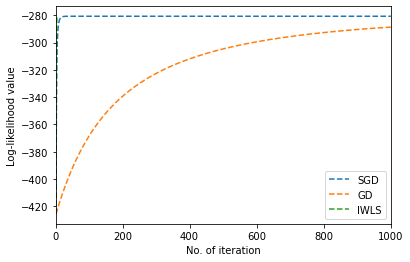

In [610]:
ax = plt.subplot(1,1,1)
plt.plot(list(range(1,len(mod_sgd.errors)+1)), mod_sgd.errors, '--')
plt.plot(list(range(1,len(mod_gd.errors)+1)), mod_gd.errors, '--')
plt.plot(list(range(1,len(mod_iwls.errors)+1)), mod_iwls.errors,'--')
plt.ylabel('Log-likelihood value')
plt.xlabel('No. of iteration')
ax.legend(['SGD', 'GD', 'IWLS'])
plt.xlim(0,1000)
plt.show()

In [459]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 4, 8]
accuracies = []
precisions = []
recalls = []
f_measures = []

for alpha in alphas:
    current_model = LogisticRegression('sgd', alpha = alpha, batch_size = 200, normalize = True)
    current_model.fit(X_train, Y_train)
    cur_Y_hat = current_model.predict(X_test, rounding = True)
    accuracies.append(accuracy(Y_test, cur_Y_hat))
    precisions.append(precision(Y_test, cur_Y_hat))
    recalls.append(recall(Y_test, cur_Y_hat))
    f_measures.append(F_measure(Y_test, cur_Y_hat))

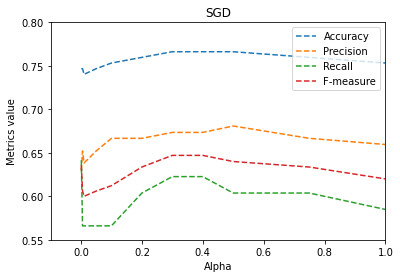

In [462]:
ax = plt.subplot(1,1,1)
plt.plot(alphas, accuracies, '--')
plt.plot(alphas, precisions, '--')
plt.plot(alphas, recalls, '--')
plt.plot(alphas, f_measures, '--')
plt.ylabel('Metrics value')
plt.xlabel('Alpha')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.title("SGD")
plt.xlim(-0.1,1)
plt.ylim(0.55,0.8)
plt.show()

In [463]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 4, 8]
accuracies = []
precisions = []
recalls = []
f_measures = []

for alpha in alphas:
    current_model = LogisticRegression('gd', alpha = alpha, batch_size = 200, normalize = True)
    current_model.fit(X_train, Y_train)
    cur_Y_hat = current_model.predict(X_test, rounding = True)
    accuracies.append(accuracy(Y_test, cur_Y_hat))
    precisions.append(precision(Y_test, cur_Y_hat))
    recalls.append(recall(Y_test, cur_Y_hat))
    f_measures.append(F_measure(Y_test, cur_Y_hat))

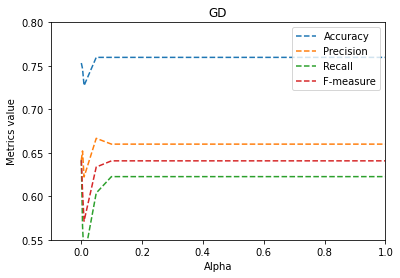

In [464]:
ax = plt.subplot(1,1,1)
plt.plot(alphas, accuracies, '--')
plt.plot(alphas, precisions, '--')
plt.plot(alphas, recalls, '--')
plt.plot(alphas, f_measures, '--')
plt.ylabel('Metrics value')
plt.xlabel('Alpha')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.title("GD")
plt.xlim(-0.1,1)
plt.ylim(0.55,0.8)
plt.show()

**Titanic**

In [611]:
np.random.seed(111)
Y = Titanic["Survived"].to_numpy()
X = Titanic.drop(columns=["Survived"]).to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [612]:
mod_sgd = LogisticRegression('sgd', alpha = 0.1, batch_size = 100, normalize = True)
mod_sgd.fit(X_train, Y_train, save_errors = True)
Y_hat_sgd = mod_sgd.predict(X_test, rounding = True)

In [613]:
assess(Y_test, Y_hat_sgd)

Acccuracy:  0.5238095238095238
Precision:  0.6
Recall:  0.07317073170731707
F_measure:  0.13043478260869565
R2_score:  -0.9058423142370962


In [614]:
mod_gd = LogisticRegression('gd', alpha = 0.1, normalize = True)
mod_gd.fit(X_train, Y_train, save_errors = True)
Y_hat_gd = mod_gd.predict(X_test, rounding = True)

In [615]:
assess(Y_test, Y_hat_gd)

Acccuracy:  0.5238095238095238
Precision:  0.5714285714285714
Recall:  0.0975609756097561
F_measure:  0.16666666666666669
R2_score:  -0.9058423142370962


In [616]:
mod_iwls = LogisticRegression('iwls', normalize = True, eps = 10**-5)
mod_iwls.fit(X_train, Y_train, save_errors = True)
Y_hat_iwls = mod_iwls.predict(X_test, rounding = True)

In [617]:
assess(Y_test, Y_hat_iwls)

Acccuracy:  0.5238095238095238
Precision:  0.5714285714285714
Recall:  0.0975609756097561
F_measure:  0.16666666666666669
R2_score:  -0.9058423142370962


In [618]:
mod_powell = LogisticRegression('powell', normalize = True)
mod_powell.fit(X_train, Y_train)
Y_hat_powell = mod_iwls.predict(X_test, rounding = True)

In [619]:
assess(Y_test, Y_hat_powell)

Acccuracy:  0.5238095238095238
Precision:  0.5714285714285714
Recall:  0.0975609756097561
F_measure:  0.16666666666666669
R2_score:  -0.9058423142370962


In [620]:
X_train_norm, X_test_norm = (X_train-X_train.mean(0))/X_train.std(0), (X_test-X_train.mean(0))/X_train.std(0)
model = sklearn.linear_model.LogisticRegression()
result = model.fit(X_train_norm, Y_train)
Y_hat = result.predict(X_test_norm)

In [621]:
assess(Y_test, Y_hat)

Acccuracy:  0.5238095238095238
Precision:  0.5714285714285714
Recall:  0.0975609756097561
F_measure:  0.16666666666666669
R2_score:  -0.9058423142370962


In [622]:
mod_lda = LinearDiscriminantAnalysis()
mod_lda = mod_lda.fit(X_train_norm, Y_train)
Y_hat_lda = mod_lda.predict(X_test_norm)

In [623]:
assess(Y_test, Y_hat_lda)

Acccuracy:  0.5238095238095238
Precision:  0.5714285714285714
Recall:  0.0975609756097561
F_measure:  0.16666666666666669
R2_score:  -0.9058423142370962


In [624]:
mod_qda = QuadraticDiscriminantAnalysis()
mod_qda = mod_qda.fit(X_train_norm, Y_train)
Y_hat_qda = mod_qda.predict(X_test_norm)

In [625]:
assess(Y_test, Y_hat_qda)

Acccuracy:  0.5833333333333334
Precision:  0.6363636363636364
Recall:  0.34146341463414637
F_measure:  0.4444444444444445
R2_score:  -0.6676120249574593


In [626]:
mod_knn = KNeighborsClassifier(n_neighbors=5)
mod_knn.fit(X_train_norm, Y_train)
Y_hat_knn = mod_knn.predict(X_test_norm)

In [627]:
assess(Y_test, Y_hat_knn)

Acccuracy:  0.6071428571428571
Precision:  0.6666666666666666
Recall:  0.3902439024390244
F_measure:  0.4923076923076923
R2_score:  -0.5723199092456044


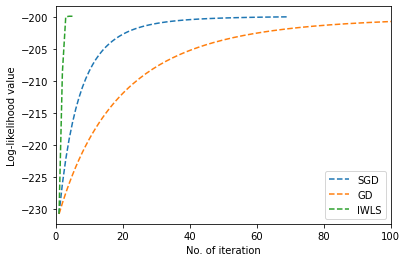

In [629]:
ax = plt.subplot(1,1,1)
plt.plot(list(range(1,len(mod_sgd.errors)+1)), mod_sgd.errors, '--')
plt.plot(list(range(1,len(mod_gd.errors)+1)), mod_gd.errors, '--')
plt.plot(list(range(1,len(mod_iwls.errors)+1)), mod_iwls.errors,'--')
plt.ylabel('Log-likelihood value')
plt.xlabel('No. of iteration')
ax.legend(['SGD', 'GD', 'IWLS'])
plt.xlim(0,100)
plt.show()

In [483]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 4, 8]
accuracies = []
precisions = []
recalls = []
f_measures = []

for alpha in alphas:
    current_model = LogisticRegression('sgd', alpha = alpha, batch_size = 200, normalize = True)
    current_model.fit(X_train, Y_train)
    cur_Y_hat = current_model.predict(X_test, rounding = True)
    accuracies.append(accuracy(Y_test, cur_Y_hat))
    precisions.append(precision(Y_test, cur_Y_hat))
    recalls.append(recall(Y_test, cur_Y_hat))
    f_measures.append(F_measure(Y_test, cur_Y_hat))

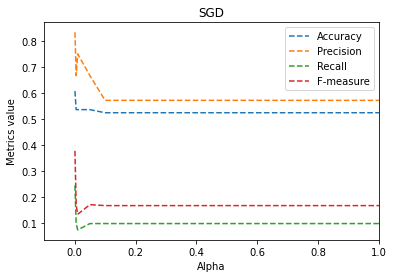

In [487]:
ax = plt.subplot(1,1,1)
plt.plot(alphas, accuracies, '--')
plt.plot(alphas, precisions, '--')
plt.plot(alphas, recalls, '--')
plt.plot(alphas, f_measures, '--')
plt.ylabel('Metrics value')
plt.xlabel('Alpha')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.title("SGD")
plt.xlim(-0.1,1)
plt.show()

In [490]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 4, 8]
accuracies = []
precisions = []
recalls = []
f_measures = []

for alpha in alphas:
    current_model = LogisticRegression('gd', alpha = alpha, batch_size = 200, normalize = True)
    current_model.fit(X_train, Y_train)
    cur_Y_hat = current_model.predict(X_test, rounding = True)
    accuracies.append(accuracy(Y_test, cur_Y_hat))
    precisions.append(precision(Y_test, cur_Y_hat))
    recalls.append(recall(Y_test, cur_Y_hat))
    f_measures.append(F_measure(Y_test, cur_Y_hat))

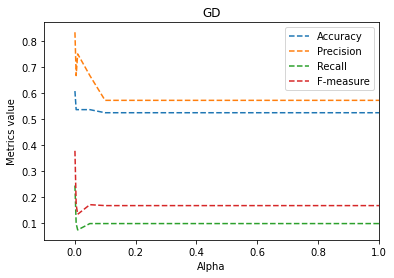

In [491]:
ax = plt.subplot(1,1,1)
plt.plot(alphas, accuracies, '--')
plt.plot(alphas, precisions, '--')
plt.plot(alphas, recalls, '--')
plt.plot(alphas, f_measures, '--')
plt.ylabel('Metrics value')
plt.xlabel('Alpha')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.title("GD")
plt.xlim(-0.1,1)
plt.show()